In [1]:
import pandas as pd
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from icecream import ic

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline

from typing import Tuple

import sys
sys.path.insert(1, r'C:\Users\GHarrison\OneDrive - Lincoln College\Python Projects\Data Science\Utilities')

from misc_tools import make_classification_dataframe, make_regression_dataframe
from pipeline_tools import DataBinaryClassifierLevel0Stacker

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\GHarrison\AppData\Roaming\Python\Python38\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
RANDOM_STATE : int = 42

FEATURE_NAME_PREFIX : str = "feature_"
TARGET_NAME : str = "target"
    
ic.enable()

results = list()

In [3]:
df_classification = make_classification_dataframe(n_samples=1200, n_features=25, n_classes=2, feature_name_prefix=FEATURE_NAME_PREFIX, target_name=TARGET_NAME, random_state=RANDOM_STATE)

X = df_classification.drop([TARGET_NAME], axis=1)
y = df_classification[TARGET_NAME]

X, X_val, y, y_val = train_test_split(X, y, test_size=200, random_state=RANDOM_STATE)

X.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25
808,1.512730,-0.169446,0.014846,-2.828687,-0.030509,2.571755,-1.063632,1.073635,0.775254,2.460824,...,0.866567,0.458418,0.147444,0.010072,-0.526291,-1.093318,0.339562,0.509393,-2.220689,2.062670
907,0.240776,0.019366,-1.430090,0.152658,0.701261,0.328040,-0.276158,-0.534686,0.378379,1.643665,...,1.423990,2.052654,1.185314,-1.046971,0.976296,1.335730,1.223209,0.174802,-0.029188,-0.484682
657,-1.346543,-0.282905,-1.247290,0.457061,-0.010965,0.272648,-1.098173,1.208717,0.613984,-0.064836,...,1.096648,0.675428,-0.237639,-1.609636,0.844471,0.490604,-1.327062,0.682108,-0.907528,0.729052
956,-0.284754,-1.049815,2.402844,1.198485,-0.214063,-0.438494,-2.103193,-0.811754,0.130803,1.349681,...,-0.050278,-0.094065,1.518612,1.673591,0.413294,2.114339,-0.045554,-0.789869,0.520921,-2.004984
885,0.130724,2.003741,1.417081,-1.149047,0.875070,2.064449,0.085855,-0.028957,-0.750355,0.103558,...,-2.152612,1.143486,-1.496239,-0.765354,-1.158733,-0.303889,-0.410975,0.201964,-0.766173,0.538481


In [4]:
level_0_classifiers = dict()
level_0_classifiers["logreg"] = LogisticRegression(random_state=RANDOM_STATE)
level_0_classifiers["forest"] = RandomForestClassifier(random_state=RANDOM_STATE)
level_0_classifiers["xgboost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
level_0_classifiers["xtrees"] = ExtraTreesClassifier(random_state=RANDOM_STATE)

level_1_classifier = ExtraTreesClassifier(random_state=RANDOM_STATE)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [5]:
sk_stacking_clf = StackingClassifier(estimators=list(level_0_classifiers.items()), final_estimator=level_1_classifier, passthrough=False, cv=kfold)

In [6]:
df_X_new_features = pd.DataFrame(sk_stacking_clf.fit_transform(X, y), columns=[f"{name}_prediction" for name in level_0_classifiers.keys()])
df_X_new_features

,logreg_prediction,forest_prediction,xgboost_prediction,xtrees_prediction
0,0.076957,0.07,0.000514,0.0
1,0.513460,0.95,0.994133,1.0
2,0.852920,0.94,0.990162,1.0
3,0.879913,0.97,0.999854,1.0
4,0.721514,0.77,0.940432,1.0
...,...,...,...,...
995,0.312670,0.09,0.010553,0.0
996,0.832097,1.00,0.999595,1.0
997,0.547054,0.11,0.018569,0.0
998,0.081879,0.02,0.002624,0.0


In [7]:
df_X_val_features = pd.DataFrame(sk_stacking_clf.transform(X_val), columns=[f"{name}_prediction" for name in level_0_classifiers.keys()])
df_X_val_features

,logreg_prediction,forest_prediction,xgboost_prediction,xtrees_prediction
0,0.098688,0.52,0.797417,0.54
1,0.680668,0.52,0.892057,0.57
2,0.118382,0.67,0.956150,0.59
3,0.408617,0.30,0.041542,0.35
4,0.376713,0.21,0.000640,0.16
...,...,...,...,...
195,0.642742,0.89,0.998618,0.82
196,0.184693,0.59,0.920475,0.64
197,0.916046,0.97,0.999343,0.93
198,0.157261,0.04,0.000503,0.11


In [8]:
pd.DataFrame(sk_stacking_clf.predict_proba(X_val)[:, 1], columns=["y_val_predict_proba"])

,y_val_predict_proba
0,0.71
1,0.85
2,0.84
3,0.01
4,0.00
...,...
195,1.00
196,0.87
197,1.00
198,0.00


In [9]:
scores = cross_val_score(sk_stacking_clf, X_val, y_val, cv=kfold)
results.append(scores)
print(f"Accuracy of scikit-learn stacking: {np.mean(scores)}")

Accuracy of scikit-learn stacking: 0.74


In [10]:
stacker = DataBinaryClassifierLevel0Stacker(cp.deepcopy(level_0_classifiers), passthrough=False, save_x=True)
level_1 = cp.deepcopy(level_1_classifier)

stacking_clf = Pipeline([
                         ('stacker', stacker), 
                         ('level_1', level_1) 
                        ])

stacking_clf.fit(X, y)
stacker.X

ic| 'DataBinaryClassifierLevel0Stacker.init'
ic| 'DataBinaryClassifierLevel0Stacker.fit'
ic| 'DataBinaryClassifierLevel0Stacker.transform'


,logreg_prediction,forest_prediction,xgboost_prediction,xtrees_prediction
0,0.076957,0.07,0.000514,0.0
1,0.513460,0.95,0.994133,1.0
2,0.852920,0.94,0.990162,1.0
3,0.879913,0.97,0.999854,1.0
4,0.721514,0.77,0.940432,1.0
...,...,...,...,...
995,0.312670,0.09,0.010553,0.0
996,0.832097,1.00,0.999595,1.0
997,0.547054,0.11,0.018569,0.0
998,0.081879,0.02,0.002624,0.0


In [11]:
y_val_predict_proba = stacking_clf.predict_proba(X_val)[:, 1]
pd.DataFrame(y_val_predict_proba, columns=["y_val_predict_proba"])

ic| 'DataBinaryClassifierLevel0Stacker.transform'


,y_val_predict_proba
0,0.71
1,0.77
2,0.87
3,0.21
4,0.12
...,...
195,0.96
196,0.85
197,1.00
198,0.09


In [12]:
stacker.X

,logreg_prediction,forest_prediction,xgboost_prediction,xtrees_prediction
0,0.098688,0.52,0.797417,0.54
1,0.680668,0.52,0.892057,0.57
2,0.118382,0.67,0.956150,0.59
3,0.408617,0.30,0.041542,0.35
4,0.376713,0.21,0.000640,0.16
...,...,...,...,...
195,0.642742,0.89,0.998618,0.82
196,0.184693,0.59,0.920475,0.64
197,0.916046,0.97,0.999343,0.93
198,0.157261,0.04,0.000503,0.11


In [13]:
scores = cross_val_score(stacking_clf, X_val, y_val, cv=kfold)
results.append(scores)
print(f"Accuracy of scratch-built stacking classifier: {np.mean(scores)}")

ic| 'DataBinaryClassifierLevel0Stacker.init'
ic| 'DataBinaryClassifierLevel0Stacker.fit'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.init'
ic| 'DataBinaryClassifierLevel0Stacker.fit'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.init'
ic| 'DataBinaryClassifierLevel0Stacker.fit'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.init'
ic| 'DataBinaryClassifierLevel0Stacker.fit'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.init'
ic| 'DataBinaryClassifierLevel0Stacker.fit'
ic| 'DataBinaryClassifierLevel0Stacker.transform'
ic| 'DataBinaryClassifierLevel0Stacker.transform'


Accuracy of scratch-built stacking classifier: 0.7699999999999999


In [14]:
for classifier_name, classifier in level_0_classifiers.items():
    scores = cross_val_score(classifier, X_val, y_val, cv=kfold)
    results.append(scores)
    print(f"Accuracy of standalone {classifier_name} classifier: {np.mean(scores)}")

Accuracy of standalone logreg classifier: 0.63
Accuracy of standalone forest classifier: 0.69
Accuracy of standalone xgboost classifier: 0.765
Accuracy of standalone xtrees classifier: 0.7449999999999999


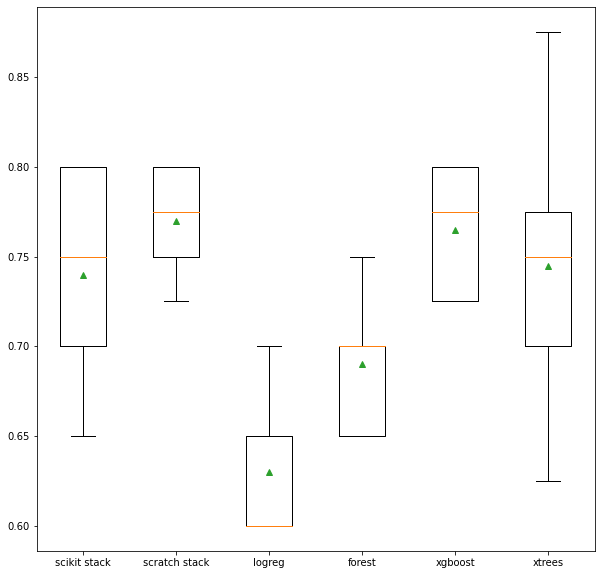

In [15]:
labels=["scikit stack", "scratch stack"] + list(level_0_classifiers.keys())

plt.figure(figsize=(10,10))
plt.boxplot(results, labels=labels, showmeans=True)
plt.show()

Grid searching next!!